# 02 Max Return from Portfolio

In [1]:
!conda env list

# conda environments:
#
base                     /home/ubuntu/anaconda3
alert                    /home/ubuntu/anaconda3/envs/alert
aws_neuron_mxnet_p36     /home/ubuntu/anaconda3/envs/aws_neuron_mxnet_p36
aws_neuron_tensorflow_p36     /home/ubuntu/anaconda3/envs/aws_neuron_tensorflow_p36
chainer_p27              /home/ubuntu/anaconda3/envs/chainer_p27
chainer_p36              /home/ubuntu/anaconda3/envs/chainer_p36
ml                    *  /home/ubuntu/anaconda3/envs/ml
mxnet_p27                /home/ubuntu/anaconda3/envs/mxnet_p27
mxnet_p36                /home/ubuntu/anaconda3/envs/mxnet_p36
python2                  /home/ubuntu/anaconda3/envs/python2
python3                  /home/ubuntu/anaconda3/envs/python3
pytorch_p27              /home/ubuntu/anaconda3/envs/pytorch_p27
pytorch_p36              /home/ubuntu/anaconda3/envs/pytorch_p36
tensorflow2_p27          /home/ubuntu/anaconda3/envs/tensorflow2_p27
tensorflow2_p36          /home/ubuntu/anaconda3/envs/tensorflow2_p36
tensorflo

In [2]:
import sys
from pathlib import Path
# add project folder to sys path
sys.path.append(str(Path.cwd().parent))

In [4]:
# import libraries
import datetime as dt
import numpy as np
import pandas as pd
import scipy.optimize as spo
from util import get_data, plot_data

In [5]:
def optimize_portfolio(sd=dt.datetime(2008, 1, 1),
                       ed=dt.datetime(2009, 1, 1),
                       syms=None,
                       gen_plot=False):
    """ Find allocation, and optimized portfolio stats """
    # Read in adjusted closing prices for given symbols, date range
    if syms is None:
        syms = ['GOOG', 'AAPL', 'GLD', 'XOM']
    dates = pd.date_range(sd, ed)
    # automatically adds SPY
    prices_all = get_data(syms, dates)
    # only portfolio symbols
    prices = prices_all[syms]
    # only SPY, for comparison later
    prices_SPY = prices_all['SPY']

    # find the allocations for the optimal portfolio
    num_of_stocks = len(syms)
    allocs = find_optimal_allocations(prices, num_of_stocks)

    # Get Cumulative Return, Average Daily Return, Volatility (stdev of daily returns)
    # Sharpe Ratio and End value
    cr, adr, sddr, sr, ev = assess_portfolio(sd=sd, ed=ed,
                                             syms=syms,
                                             allocs=allocs,
                                             gen_plot=False)

    # Get daily portfolio value
    port_val = get_portfolio_value(normalize_df(prices),
                                   allocs,
                                   start_val=1000000)

    # Compare daily portfolio value with SPY using a normalized plot
    if gen_plot:
        df_temp = pd.concat([port_val, prices_SPY], keys=['Portfolio', 'SPY'], axis=1)
        plot_normalized_data(df_temp, title="Daily Portolio Value and SPY")

    return allocs, cr, adr, sddr, sr

In [6]:
def find_optimal_allocations(prices, num_of_stocks):
    """ Use Scipy to find optimized portfolio allocation """

    # bounds for all stock allocation would be 0 - 1
    bounds = [(0, 1)] * num_of_stocks
    # allocation must sum to 1
    constraints = ({'type': 'eq', 'fun': lambda inputs: 1.0 - np.sum(inputs)})
    # intial guess balanced alloc
    x0 = np.ones(num_of_stocks) * (1. / num_of_stocks)
    # Use negative Sharpe ratio to optimize (minimize)
    result = spo.minimize(negative_sharpe, x0, prices, method='SLSQP',
                          bounds=bounds, constraints=constraints)
    return result.x

In [7]:
def negative_sharpe(X, prices, samples_per_year=252., risk_free_rate=0., sv=1000000):
    """ Return portfolio's negative sharpe ratio """
    # Get daily portfolio value
    port_val = get_portfolio_value(normalize_df(prices), X, sv)
    # Get portfolio statistics (note: std_daily_ret = volatility)
    daily_rets = compute_daily_returns(port_val)[1:]
    # Get portfolio stats
    cr, adr, sddr, sr = get_portfolio_stats(port_val, daily_rets,
                                            samples_per_year, risk_free_rate)
    return -sr

In [8]:
def compute_daily_returns(df):
    """Compute and return the daily return values."""
    return ((df / df.shift(1)) - 1).fillna(0)

In [9]:
def get_portfolio_value(prices, allocs, start_val):
    """ Compute daily portfolio value given stock prices, allocations and starting value.

        Return: pandas Series or DataFrame (with a single column)
    """
    return (prices * allocs).sum(1) * start_val

In [10]:
def get_portfolio_stats(port_val, daily_rf, samples_per_year, risk_free_rate):
    """ Calculate statistics on daily portfolio value, given daily risk-free rate and data sampling frequency.

        Return: a tuple consisting of the following statistics (in order): cumulative return, average daily return, standard deviation of daily return, Sharpe ratio
        Note: The return statement provided ensures this order.
    """

    # Get portfolio statistics (note: std_daily_ret = volatility)
    daily_rf = compute_daily_returns(port_val)[1:]
    cr = get_cumulative_return(port_val)
    adr = daily_rf.mean()
    sddr = daily_rf.std()

    # Sharpe ratio = K * (Return of Portfolio - Risk-free Rate) / SD of portfolio's excess return
    # Daily sampling K = sqrt(252.)
    sr = np.sqrt(samples_per_year) * (adr - risk_free_rate) / sddr

    return cr, adr, sddr, sr

In [17]:
def normalize_df(port_val):
    """ Return normalized dataframe starting with 1.0 """
    return port_val / port_val.iloc[0]

In [12]:
def get_cumulative_return(df):
    """ Get Cumulative return of Portfolio"""
    return df[-1] / df[0] - 1.

In [13]:
def plot_normalized_data(df, title="Portfolio vs SPY", xlabel="Date", ylabel="Normalized Return"):
    """ Plot normalized return """
    plot_data(normalize_df(df), title, xlabel, ylabel)

In [14]:
def assess_portfolio(sd=dt.datetime(2008, 1, 1), ed=dt.datetime(2009, 1, 1),
                     syms=None,
                     allocs=None,
                     sv=1000000,
                     rfr=0.0,
                     sf=252.0,
                     gen_plot=False):
    # Read in adjusted closing prices for given symbols, date range
    if syms is None:
        syms = ['GOOG', 'AAPL', 'GLD', 'XOM']
    if allocs is None:
        allocs = [0.1, 0.2, 0.3, 0.4]
    # get date range
    dates = pd.date_range(sd, ed)
    # print dates
    prices_all = get_data(syms, dates)  # automatically adds SPY
    # print prices_all.head()
    prices = prices_all[syms]  # only portfolio symbols
    # print prices.head()
    prices_SPY = prices_all['SPY']  # only SPY, for comparison later

    # Get daily portfolio value
    port_val = get_portfolio_value(normalize_df(prices), allocs, sv)

    # Get portfolio statistics (note: std_daily_ret = volatility)
    daily_rets = compute_daily_returns(port_val)[1:]

    cr, adr, sddr, sr = get_portfolio_stats(port_val, daily_rf=daily_rets,
                                            samples_per_year=sf, risk_free_rate=rfr)

    # Compare daily portfolio value with SPY using a normalized plot
    if gen_plot:
        # add code to plot here
        df_temp = pd.concat([port_val, prices_SPY], keys=['Portfolio', 'SPY'], axis=1)
        plot_normalized_data(df_temp)

    # Add code here to properly compute end value
    ev = port_val[-1]

    return cr, adr, sddr, sr, ev

In [21]:
!pip install tabulate

     |████████████████████████████████| 45 kB 4.9 MB/s  eta 0:00:01
  Created wheel for tabulate: filename=tabulate-0.8.6-py3-none-any.whl size=23272 sha256=4dba958f7208b4460c6044bd8d54325a5c380d91af5041be74da3ef82b64da6e
  Stored in directory: /home/ubuntu/.cache/pip/wheels/f1/f8/e3/a65c54a883edf04f7d6b0eda5486e6f27279354b84fd932da2
Successfully built tabulate


In [22]:
from tabulate import tabulate

In [25]:
def test_code():
    # This function WILL NOT be called by the auto grader
    # Do not assume that any variables defined here are available to your function/code
    # It is only here to help you set up and test your code

    # Define input parameters
    # Note that ALL of these values will be set to different values by
    # the autograder!

    start_date = dt.datetime(2008, 6, 1)
    end_date = dt.datetime(2009, 6, 1)
    symbols = ['IBM', 'X', 'GLD', 'JPM']

    # Assess the portfolio
    allocations, cr, adr, sddr, sr = optimize_portfolio(sd=start_date,
                                                        ed=end_date,
                                                        syms=symbols,
                                                        gen_plot=True)

    output = tabulate([['Start Date', start_date],
                       ['End Date', end_date],
                       ['Symbols', symbols],
                       ['Allocations', allocations],
                       ['Sharpe Ratio', sr],
                       ['Volatility', sddr],
                       ['Average Daily Return', adr],
                       ['Cumulative Return', cr]],
                      headers=['Name', 'Value'])

    print(output)

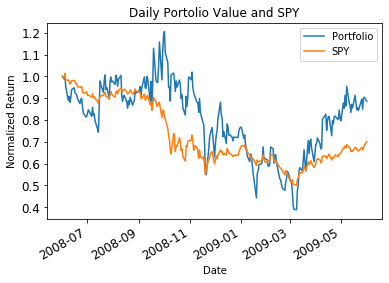

Name                  Value
--------------------  -------------------------------------------------------------
Start Date            2008-06-01 00:00:00
End Date              2009-06-01 00:00:00
Symbols               ['IBM', 'X', 'GLD', 'JPM']
Allocations           [5.55111512e-17 1.66533454e-16 0.00000000e+00 1.00000000e+00]
Sharpe Ratio          0.42310717924180125
Volatility            0.06891106884929615
Average Daily Return  0.0018367037394021754
Cumulative Return     -0.11480908152734781


In [26]:
test_code()